In [3]:
# GENERICOS
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# DECOMPOSE
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# TESTS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# MODELOS
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
df_base = pd.read_csv('../data/processed/data_processed_1990_2023.csv', index_col='fecha')
df_base.drop('target', axis=1, inplace=True)
df_base.index = pd.to_datetime(df_base.index)
df_base.tail(7)

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2023-03-06,10.3,15.9,13.1,1008.7,1013.4,21.0,1.9,8.3,0.0,3.3
2023-03-07,12.9,19.7,16.3,1009.8,1013.4,22.0,3.9,10.3,3.2,0.6
2023-03-08,14.4,20.5,17.4,1011.6,1015.1,22.0,6.1,10.3,3.2,2.5
2023-03-09,13.6,20.5,17.0,1013.7,1019.5,21.0,5.3,12.5,3.0,0.9
2023-03-10,8.9,21.8,15.4,1019.2,1022.5,99.0,1.7,6.7,10.5,0.1
2023-03-11,8.9,24.0,16.4,1018.7,1022.2,99.0,2.8,7.8,9.9,0.0
2023-03-12,9.5,26.5,18.0,1014.1,1020.3,8.0,2.2,8.3,10.6,0.0


In [5]:
df_last_year = df_base.iloc[-365:]
df_last_year.head()

,tmin,tmax,tmed,presMin,presMax,dir,velmedia,racha,sol,prec
fecha,,,,,,,,,,
2022-03-13,11.0,18.1,14.6,1006.7,1013.8,21.0,1.7,7.8,6.8,12.7
2022-03-14,10.1,14.7,12.4,999.7,1006.7,99.0,4.7,13.9,0.9,1.0
2022-03-15,10.7,16.0,13.4,1002.8,1008.5,7.0,2.8,16.4,0.0,6.4
2022-03-16,11.7,13.5,12.6,1005.8,1012.2,8.0,1.1,9.7,0.0,2.9
2022-03-17,11.1,18.4,14.8,1011.3,1016.7,6.0,3.6,10.3,0.0,0.0


- Trabajamos con TMED

In [6]:
tmed = df_base['tmed']
tmed_last_year = df_last_year['tmed']

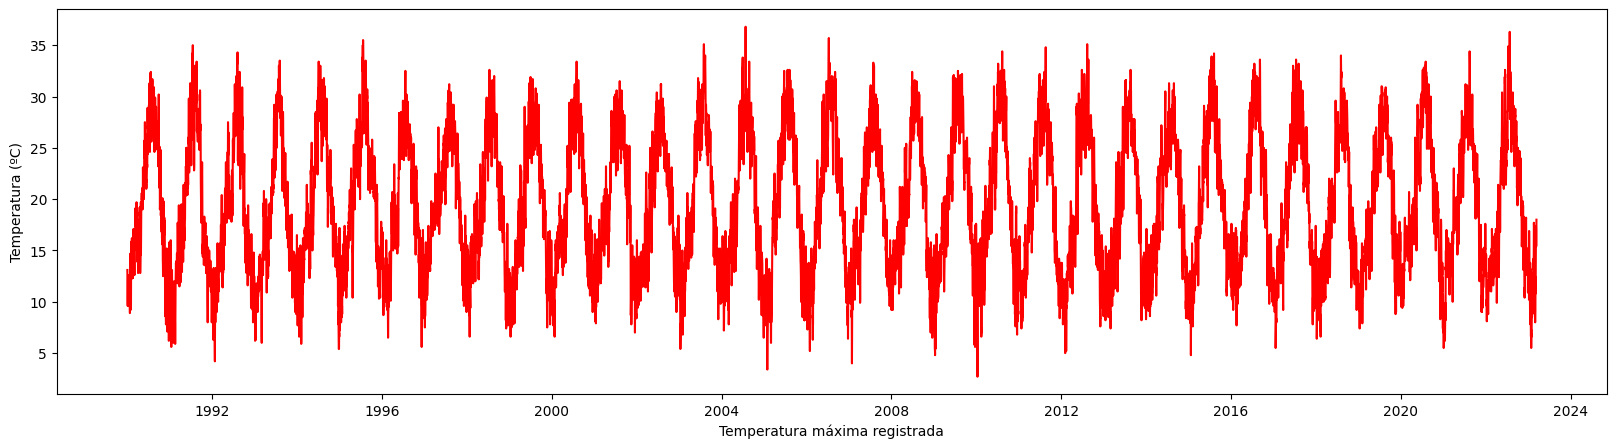

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tmed, color='red')
ax.set_xlabel('Temperatura máxima registrada')
ax.set_ylabel('Temperatura (ºC)')
plt.show()

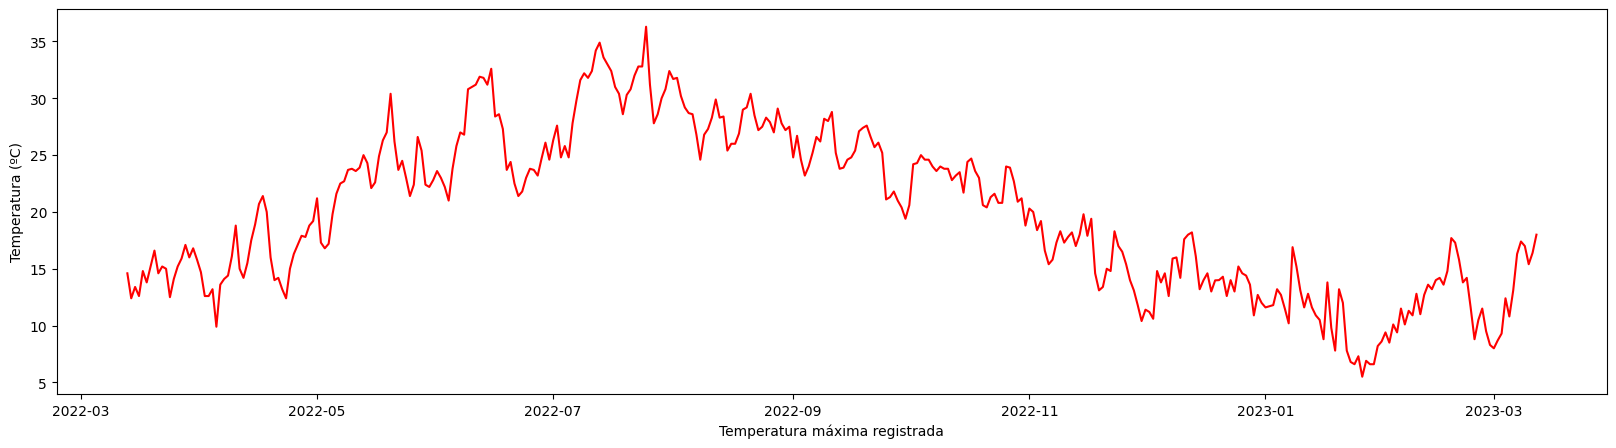

In [8]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tmed_last_year, color='red')
ax.set_xlabel('Temperatura máxima registrada')
ax.set_ylabel('Temperatura (ºC)')
plt.show()

Veamos la descomposición en los ultimos 365 días para más claridad.

Dado que la magnitud no cambia con el tiempo, usamos la aditiva.

In [9]:
df_adf = adfuller(tmed, autolag = 'AIC')
print("1. ADF : ",df_adf[0])
print("2. P-Value : ", df_adf[1])
print("3. Num Of Lags : ", df_adf[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", df_adf[3])
print("5. Critical Values :")
for key, val in df_adf[4].items():
    print("\t",key, ": ", val)
print(f"Resultado: La serie es {'no' if df_adf[1] > 0.05 else ''}estacionaria")

1. ADF :  -8.594098639880192
2. P-Value :  7.154826175329681e-14
3. Num Of Lags :  40
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 12083
5. Critical Values :
	 1% :  -3.430891313396391
	 5% :  -2.861779232863024
	 10% :  -2.5668973386142
Resultado: La serie es estacionaria


In [10]:
df_kpss = kpss(tmed)
print("1. KPSS : ",df_kpss[0])
print("2. P-Value : ", df_kpss[1])
print("3. Num Of Lags : ", df_kpss[2])
print("4. Critical Values :")
for key, val in df_kpss[3].items():
    print("\t",key, ": ", val)
print(f"Resultado: La serie es {'no' if df_kpss[1] < 0.05 else ''}estacionaria")

1. KPSS :  0.02587126548094913
2. P-Value :  0.1
3. Num Of Lags :  67
4. Critical Values :
	 10% :  0.347
	 5% :  0.463
	 2.5% :  0.574
	 1% :  0.739
Resultado: La serie es estacionaria


C:\Users\jdelacu1\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


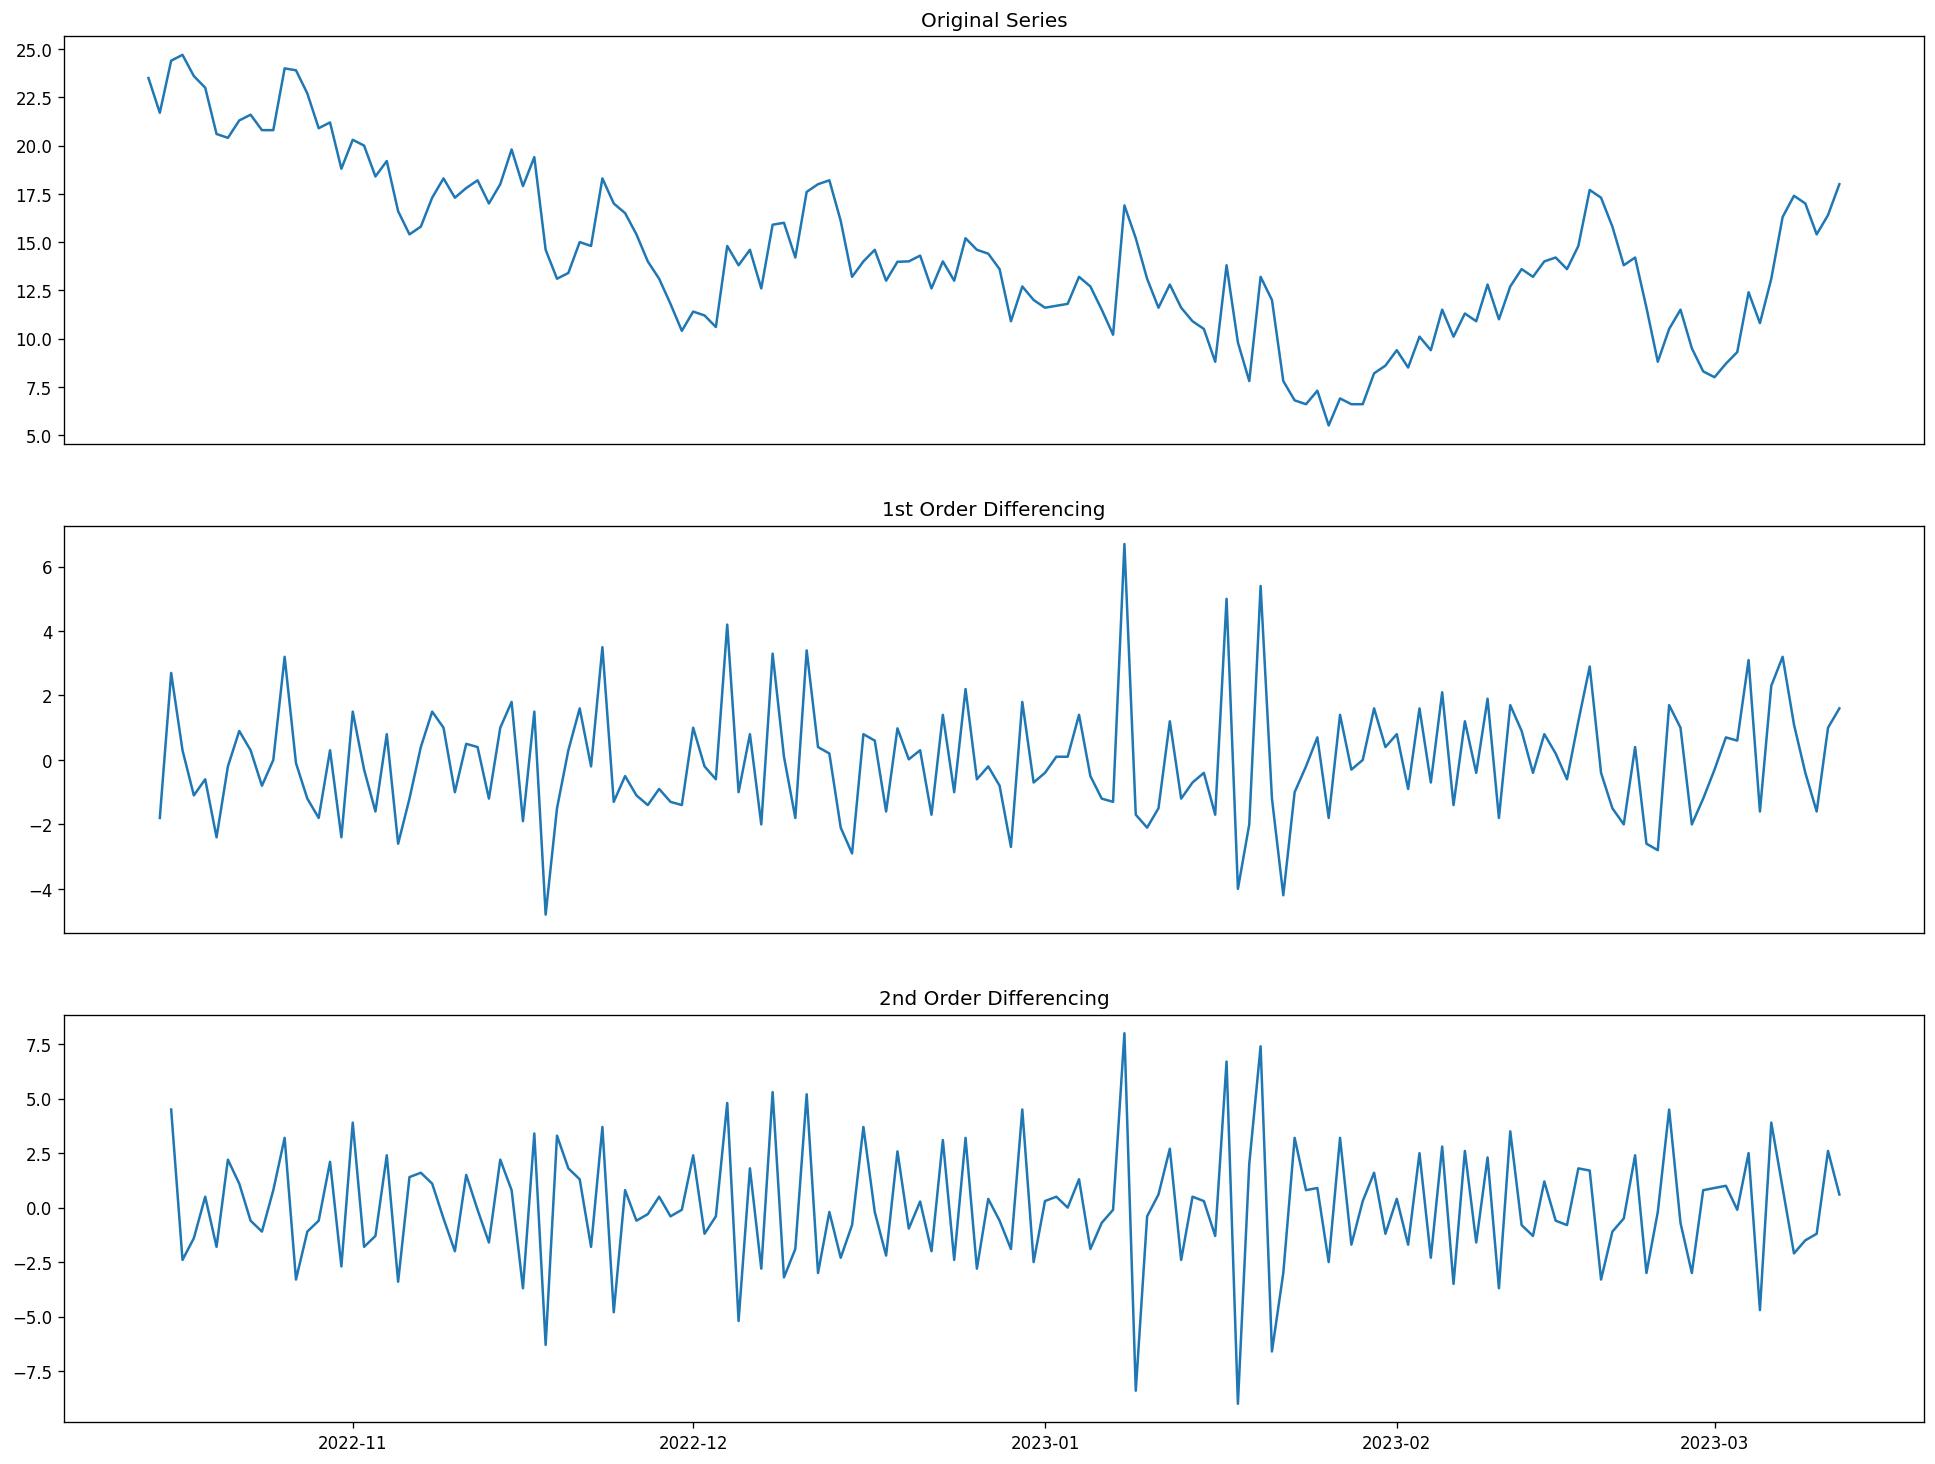

In [20]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
axes[0].plot(tmed[-150:]); axes[0].set_title('Original Series'); axes[0].axes.xaxis.set_visible(False)
# 1st Differencing
axes[1].plot(tmed[-150:].diff()); axes[1].set_title('1st Order Differencing'); axes[1].axes.xaxis.set_visible(False)
# 2nd Differencing
axes[2].plot(tmed[-150:].diff().diff()); axes[2].set_title('2nd Order Differencing')
plt.show()

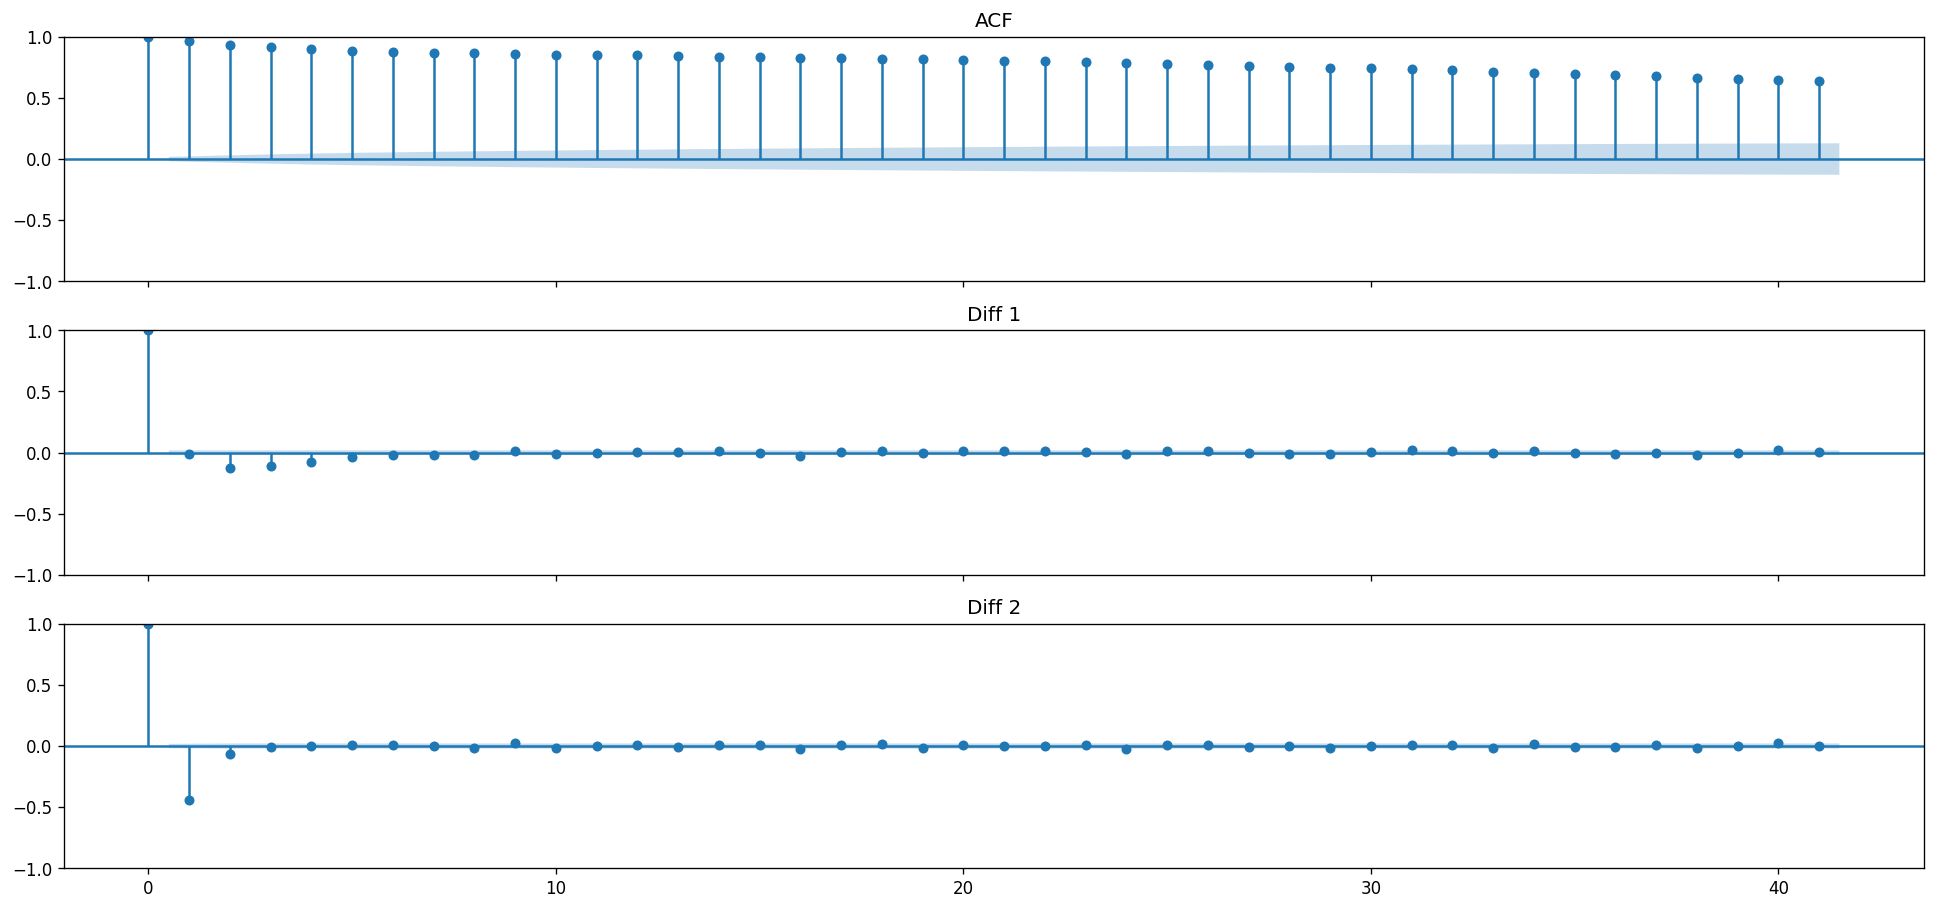

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 9), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})
plot_acf(tmed, ax=axes[0])
plot_acf(tmed.diff().dropna(), ax=axes[1])
plot_acf(tmed.diff().diff().dropna(), ax=axes[2])

axes[0].set_title('ACF')
axes[1].set_title('Diff 1')
axes[2].set_title('Diff 2')

plt.show()

- Creo que con diferenciar una vez vale

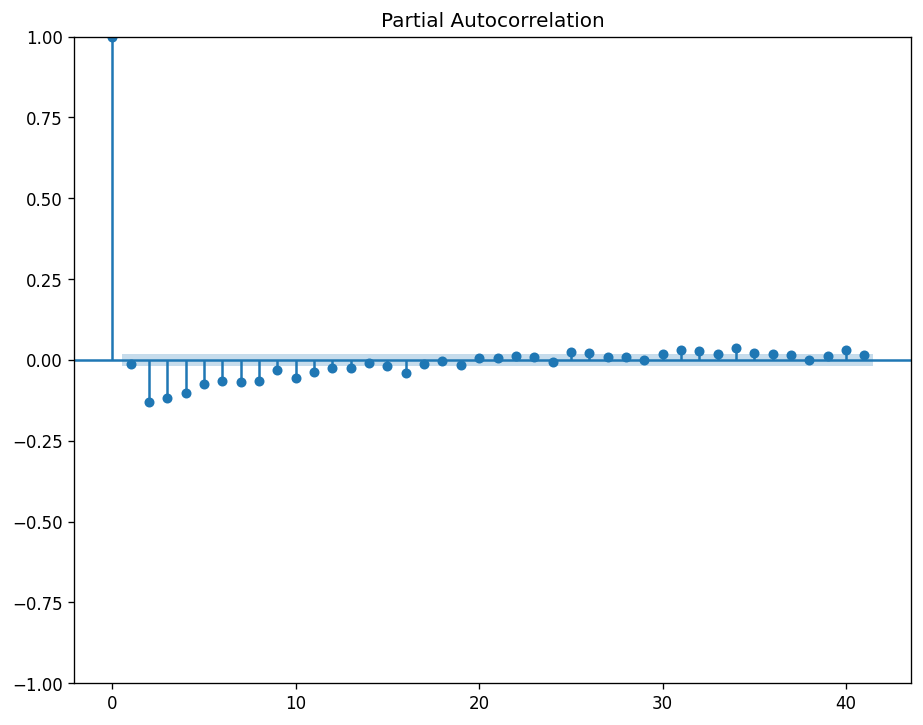

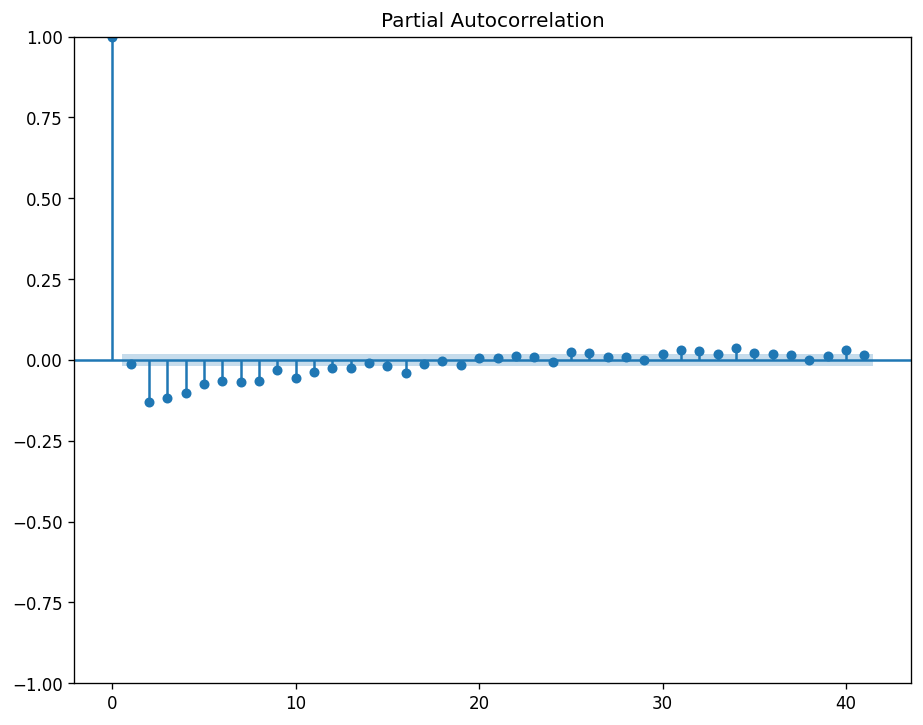

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(tmed.diff().dropna())